In [24]:
import atlite
import xarray as xr
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from _helpers import (
    load_gis_data,
    generate_pv_timeseries,
    aggregate_intra_region,
)

In [25]:
data_bundle_path = "../../data/bundle"
gis_data = load_gis_data(data_bundle_path)

Loading Eskom Supply Regions from ../../data/bundle/rsa_supply_regions.gpkg
Loading EIA applications from ../../data/bundle/REEA_OR_2023_Q3.shp
Loading REDZs from ../../data/bundle/REDZs.shp
Loading Power Corridors from ../../data/bundle/Power_corridors.shp
Loading SACAD from ../../data/bundle/SACAD_OR_2023_Q3.shp
Loading SAPAD from ../../data/bundle/SAPAD_OR_2023_Q3.shp
Loading SKA exclusion from ../../data/bundle/SKA/SKA_exclusion.shp


# Comparison of fixed generators to Eskom data
Based on historical performance of aggregated wind and solar PV generators from REIPPPP

In [26]:
#load Eskom data portal data
eskom_data = pd.read_csv('../../data/eskom_data.csv', index_col=0, parse_dates=True)

In [27]:
fixed_solar_pv={}
fixed_solar_pv["era5"] = xr.open_dataarray('timeseries_data/fixed_solar_pv_era5.nc')
fixed_solar_pv["sarah"] = xr.open_dataarray('timeseries_data/fixed_solar_pv_sarah.nc')
fixed_solar_pv["pysam"] = xr.open_dataarray('timeseries_data/fixed_solar_pv_pysam.nc')

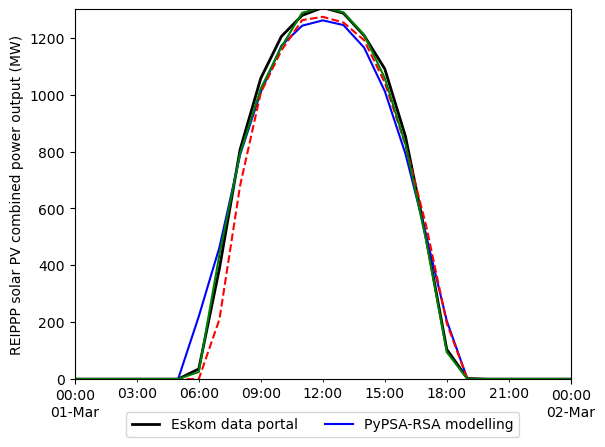

In [41]:

eskom_data["PV"].plot(color='k', lw=2, label='Eskom Data Portal')
fixed_solar_pv["era5"].sel(dict(param="power")).sum("plant").to_series().plot(color='b', label='era5')
fixed_solar_pv["sarah"].sel(dict(param="power")).sum("plant").to_series().plot(color='r', ls='--', label='sarah')
fixed_solar_pv["pysam"].sel(dict(param="power")).sum("plant").to_series().plot(color='g', label='pysam')
plt.legend(["Eskom data portal", "PyPSA-RSA modelling"],loc='upper center', bbox_to_anchor=(0.5, -0.07), ncol=2)
plt.ylabel("REIPPP solar PV combined power output (MW)")
plt.xlabel("")

plt.xlim("2019-03-01", "2019-03-02")
plt.ylim(0,1300)
plt.savefig("solar_pv_comparison.png", dpi=300)

In [29]:
fixed_wind={}
fixed_wind["era5"] = xr.open_dataarray('timeseries_data/fixed_wind_era5.nc')
fixed_wind["wasa"] = xr.open_dataarray('timeseries_data/fixed_wind_wasa.nc')

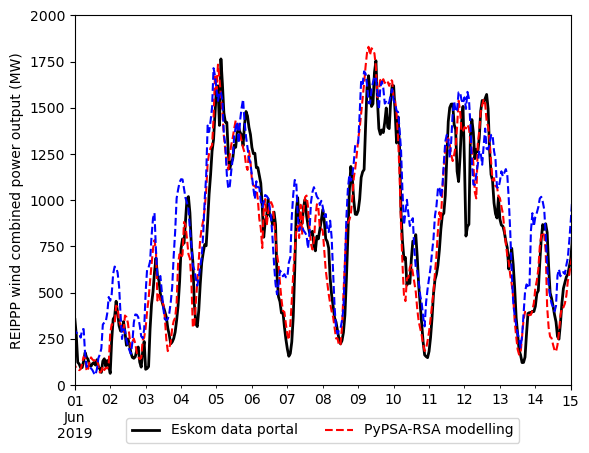

In [45]:
eskom_data["Wind"].plot(color='k', lw=2, label='Eskom Data Portal')
fixed_wind["era5"].sel(dict(param="power")).sum("plant").to_series().plot(color='r', ls='--', label='era5')
fixed_wind["wasa"].sel(dict(param="power")).sum("plant").to_series().plot(color='b', ls='--', label='WASA')

plt.legend(["Eskom data portal", "PyPSA-RSA modelling"],loc='upper center', bbox_to_anchor=(0.5, -0.07), ncol=2)
plt.ylabel("REIPPP wind combined power output (MW)")

plt.xlabel("")
plt.xlim("2019-06-01", "2019-06-15")
plt.ylim(0,2000)
plt.savefig("wind_comparison.png", dpi=300)

# Compare to CSIR/Fraunhofer regional data for 27 supply areas

In [31]:
wasa_pu = xr.open_dataarray("timeseries_data/extendable_wind_wasa_27.nc")
era5_pu = xr.open_dataarray("timeseries_data/extendable_wind_era5_27.nc")

In [32]:
csir_wind_data = pd.read_excel(
    f'{data_bundle_path}/Supply area normalised power feed-in for Wind.xlsx',
    sheet_name='Wind power profiles',
    index_col=0,
    skiprows=[1]
).resample('H').mean()

<Axes: title={'center': 'Wind power profiles for 2012'}>

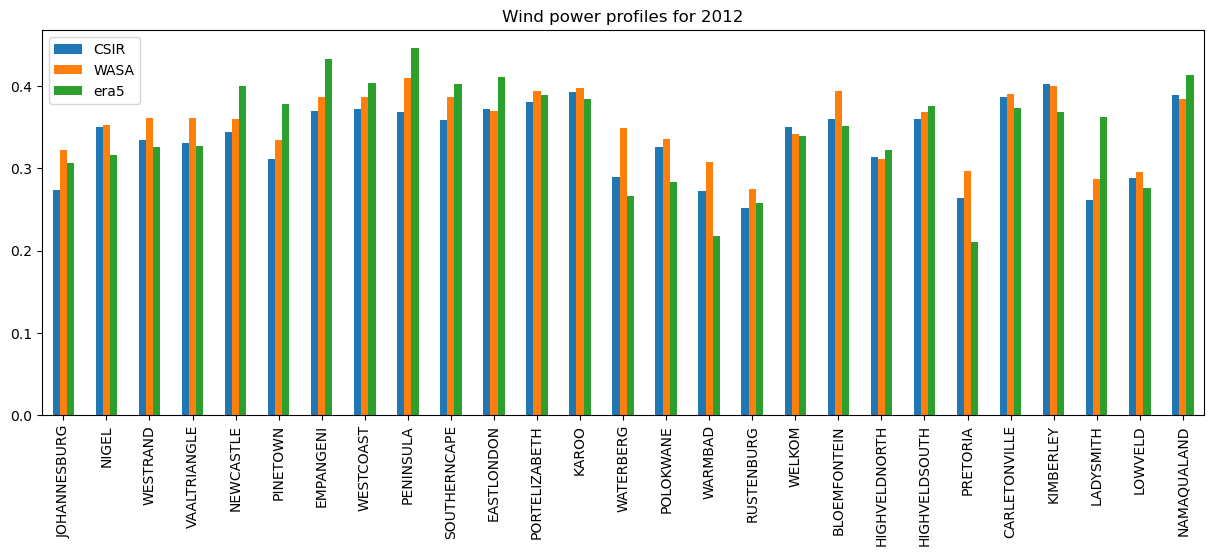

In [33]:
df1 = era5_pu.sel({"time":"2012", "intra_region":"all"}).mean("time").to_series()
df1.index = df1.index.str.upper().str.replace(" ", "")

df2 = wasa_pu.sel({"time":"2012", "intra_region":"all"}).mean("time").to_series()
df2.index = df1.index.str.upper().str.replace(" ", "")

data = csir_wind_data.loc["2012"].mean().to_frame('CSIR')
data.index = data.index.str.upper().str.replace(" ", "")

data["WASA"] = 0
for idx in df1.index:
    data.loc[idx, 'era5'] = df1.loc[idx]
    data.loc[idx, 'WASA'] = df2.loc[idx]

data.plot(kind='bar', figsize=(15, 5), title="Wind power profiles for 2012")

<Axes: title={'center': 'Wind power profiles for 2013'}>

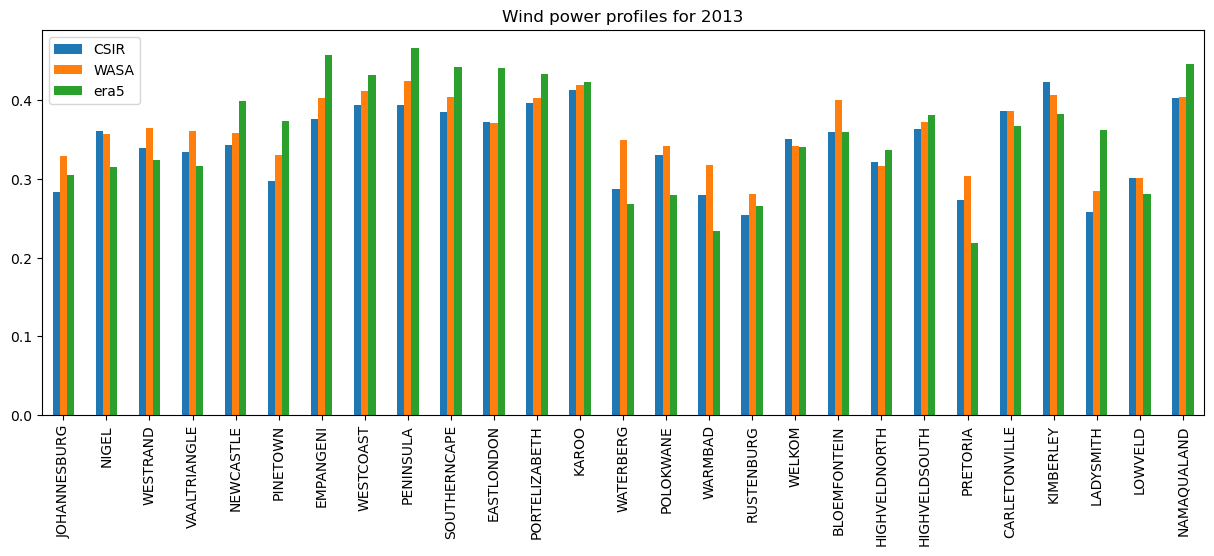

In [46]:
df1 = era5_pu.sel({"time":"2013", "intra_region":"all"}).mean("time").to_series()
df1.index = df1.index.str.upper().str.replace(" ", "")

df2 = wasa_pu.sel({"time":"2013", "intra_region":"all"}).mean("time").to_series()
df2.index = df1.index.str.upper().str.replace(" ", "")

data = csir_wind_data.loc["2013"].mean().to_frame('CSIR')
data.index = data.index.str.upper().str.replace(" ", "")

data["WASA"] = 0
for idx in df1.index:
    data.loc[idx, 'era5'] = df1.loc[idx]
    data.loc[idx, 'WASA'] = df2.loc[idx]

data.plot(kind='bar', figsize=(15, 5), title="Wind power profiles for 2013")

In [35]:
csir_solar_pv_data = pd.read_excel(
    f'{data_bundle_path}/Supply area normalised power feed-in for PV.xlsx',
    sheet_name='PV profiles',
    index_col=0,
    skiprows=[1]
).resample('H').mean()

In [36]:
solar_pv_era5_pu = xr.open_dataarray("timeseries_data/extendable_solar_pv_era5_27_2012.nc")
solar_pv_sarah_pu = xr.open_dataarray("timeseries_data/extendable_solar_pv_sarah_27_2012.nc")

<Axes: title={'center': 'PV power profiles for 2012'}>

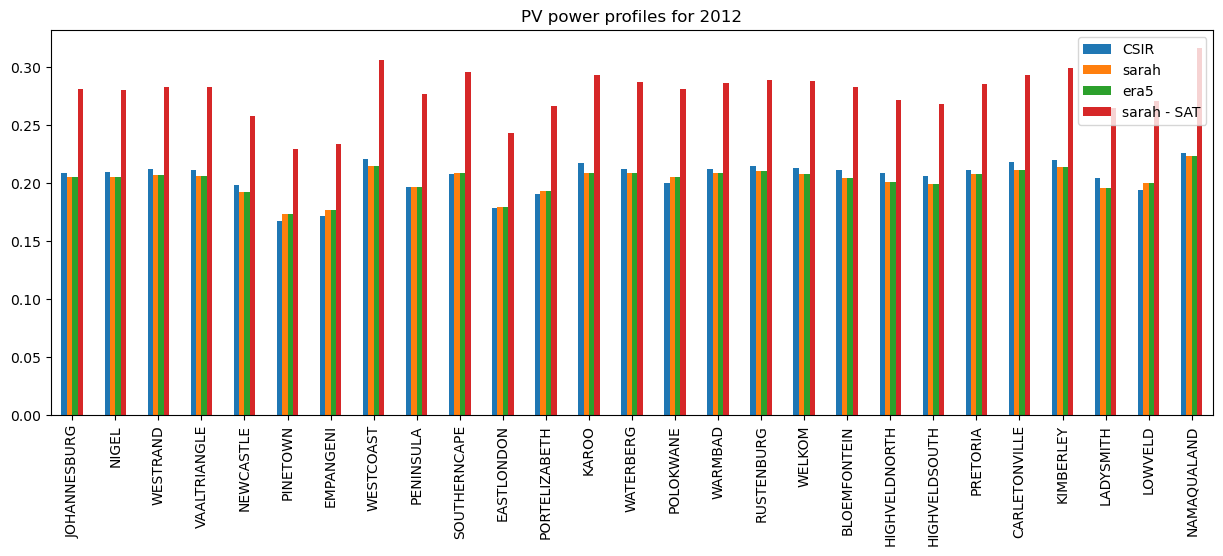

In [37]:
df1_ft = solar_pv_era5_pu.sel({"time":"2012", "intra_region":"all", "_type": "Fixed Tilt"}).mean("time").to_series()
df1_ft.index = df1_ft.index.str.upper().str.replace(" ", "")

df1_rf = solar_pv_era5_pu.sel({"time":"2012", "intra_region":"all", "_type": "Rooftop"}).mean("time").to_series()
df1_rf.index = df1_rf.index.str.upper().str.replace(" ", "")
df1 = 0.3*df1_ft + 0.7*df1_rf

df2_ft = solar_pv_sarah_pu.sel({"time":"2012", "intra_region":"all", "_type": "Fixed Tilt"}).mean("time").to_series()
df2_ft.index = df2_ft.index.str.upper().str.replace(" ", "")

df2_rf = solar_pv_sarah_pu.sel({"time":"2012", "intra_region":"all", "_type": "Rooftop"}).mean("time").to_series()
df2_rf.index = df2_rf.index.str.upper().str.replace(" ", "")
df2 = 0.3*df2_ft + 0.7*df2_rf

df2_sat = solar_pv_sarah_pu.sel({"time":"2012", "intra_region":"all", "_type": "Single Axis"}).mean("time").to_series()
df2_sat.index = df2_sat.index.str.upper().str.replace(" ", "")

data = csir_solar_pv_data.loc["2012"].mean().to_frame('CSIR')
data.index = data.index.str.upper().str.replace(" ", "")

data["sarah"] = 0
for idx in df1.index:
    data.loc[idx, 'era5'] = df1.loc[idx]
    data.loc[idx, 'sarah'] = df2.loc[idx]
    data.loc[idx, 'sarah - SAT'] = df2_sat.loc[idx]

data.plot(kind='bar', figsize=(15, 5), title="PV power profiles for 2012")